In [1]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as stat
from statsmodels.tsa.arima.model import ARIMA
import psycopg2
from psycopg2 import sql
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
!pip install pmdarima
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

from scipy.optimize import minimize

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

In [2]:
apple = pd.read_csv('stock-price-prediction-challenge/train/stocks/AAPL.csv')
apple.to_csv("apple.csv", index=False)
apple.info()
apple

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2569 entries, 0 to 2568
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2569 non-null   object 
 1   Ticker    2569 non-null   object 
 2   Open      2569 non-null   float64
 3   High      2569 non-null   float64
 4   Low       2569 non-null   float64
 5   Close     2569 non-null   float64
 6   Adjusted  2569 non-null   float64
 7   Returns   2569 non-null   float64
 8   Volume    2569 non-null   int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 180.8+ KB


Date Ticker        Open        High         Low       Close  \
0     2015-01-05   AAPL   27.072500   27.162500   26.352501   26.562500   
1     2015-01-06   AAPL   26.635000   26.857500   26.157499   26.565001   
2     2015-01-07   AAPL   26.799999   27.049999   26.674999   26.937500   
3     2015-01-08   AAPL   27.307501   28.037500   27.174999   27.972500   
4     2015-01-09   AAPL   28.167500   28.312500   27.552500   28.002501   
...          ...    ...         ...         ...         ...         ...   
2564  2025-03-17   AAPL  213.309998  215.220001  209.970001  214.000000   
2565  2025-03-18   AAPL  214.160004  215.149994  211.490005  212.690002   
2566  2025-03-19   AAPL  214.220001  218.759995  213.750000  215.240005   
2567  2025-03-20   AAPL  213.990005  217.490005  212.220001  214.100006   
2568  2025-03-21   AAPL  211.559998  218.839996  211.279999  218.270004   

        Adjusted   Returns     Volume  
0      23.635283 -0.028172  257142000  
1      23.637512  0.000094  263188400  
2      23.968964  0.014022  160423600  
3      24.889904  0.038422  237458000  
4      24.916595  0.001072  214798000  
...          ...       ...        ...  
2564  214.000000  0.002389   48073400  
2565  212.690002 -0.006121   42432400  
2566  215.240005  0.011989   54385400  
2567  214.100006 -0.005296   48862900  
2568  218.270004  0.019477   94127800  

[2569 rows x 9 columns]

In [3]:
# Parse Date column into datetime
apple['Date'] = pd.to_datetime(apple['Date'], errors='coerce')
# Drop rows with invalid dates (if any parsing failed)
apple = apple.dropna(subset=['Date'])
# Sort chronologically
apple = apple.sort_values('Date')
apple.info()
apple

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2569 entries, 0 to 2568
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2569 non-null   datetime64[ns]
 1   Ticker    2569 non-null   object        
 2   Open      2569 non-null   float64       
 3   High      2569 non-null   float64       
 4   Low       2569 non-null   float64       
 5   Close     2569 non-null   float64       
 6   Adjusted  2569 non-null   float64       
 7   Returns   2569 non-null   float64       
 8   Volume    2569 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 180.8+ KB


Date Ticker        Open        High         Low       Close  \
0    2015-01-05   AAPL   27.072500   27.162500   26.352501   26.562500   
1    2015-01-06   AAPL   26.635000   26.857500   26.157499   26.565001   
2    2015-01-07   AAPL   26.799999   27.049999   26.674999   26.937500   
3    2015-01-08   AAPL   27.307501   28.037500   27.174999   27.972500   
4    2015-01-09   AAPL   28.167500   28.312500   27.552500   28.002501   
...         ...    ...         ...         ...         ...         ...   
2564 2025-03-17   AAPL  213.309998  215.220001  209.970001  214.000000   
2565 2025-03-18   AAPL  214.160004  215.149994  211.490005  212.690002   
2566 2025-03-19   AAPL  214.220001  218.759995  213.750000  215.240005   
2567 2025-03-20   AAPL  213.990005  217.490005  212.220001  214.100006   
2568 2025-03-21   AAPL  211.559998  218.839996  211.279999  218.270004   

        Adjusted   Returns     Volume  
0      23.635283 -0.028172  257142000  
1      23.637512  0.000094  263188400  
2      23.968964  0.014022  160423600  
3      24.889904  0.038422  237458000  
4      24.916595  0.001072  214798000  
...          ...       ...        ...  
2564  214.000000  0.002389   48073400  
2565  212.690002 -0.006121   42432400  
2566  215.240005  0.011989   54385400  
2567  214.100006 -0.005296   48862900  
2568  218.270004  0.019477   94127800  

[2569 rows x 9 columns]

In [4]:
# Remove duplicates: keep the last record if a date appears twice
before = len(apple)
apple = apple.drop_duplicates(subset=['Date'], keep='last')
after = len(apple)

print(f"Removed {before - after} duplicate rows")


Removed 0 duplicate rows


In [5]:
apple.set_index('Date', inplace=True)

In [6]:
# Compute 20-day moving average. 20 days is around the number of days in a trading month.
window = 20
apple['MA20'] = apple['Adjusted'].rolling(window=window).mean()

apple['STD20'] = apple['Adjusted'].rolling(window).std()
apple['Lower'] = apple['MA20'] - (2 * apple['STD20'])
apple['Upper'] = apple['MA20'] + (2 * apple['STD20'])


apple['EMA20'] = apple['Adjusted'].ewm(span=window, adjust=False).mean()

apple.head(50)

Ticker       Open       High        Low      Close   Adjusted  \
Date                                                                       
2015-01-05   AAPL  27.072500  27.162500  26.352501  26.562500  23.635283   
2015-01-06   AAPL  26.635000  26.857500  26.157499  26.565001  23.637512   
2015-01-07   AAPL  26.799999  27.049999  26.674999  26.937500  23.968964   
2015-01-08   AAPL  27.307501  28.037500  27.174999  27.972500  24.889904   
2015-01-09   AAPL  28.167500  28.312500  27.552500  28.002501  24.916595   
2015-01-12   AAPL  28.150000  28.157499  27.200001  27.312500  24.302641   
2015-01-13   AAPL  27.857500  28.200001  27.227501  27.555000  24.518415   
2015-01-14   AAPL  27.260000  27.622499  27.125000  27.450001  24.424986   
2015-01-15   AAPL  27.500000  27.514999  26.665001  26.705000  23.762081   
2015-01-16   AAPL  26.757500  26.895000  26.299999  26.497499  23.577448   
2015-01-20   AAPL  26.959999  27.242500  26.625000  27.180000  24.184738   
2015-01-21   AAPL  27.237499  27.764999  27.067499  27.387501  24.369373   
2015-01-22   AAPL  27.565001  28.117500  27.430000  28.100000  25.003349   
2015-01-23   AAPL  28.075001  28.437500  27.882500  28.245001  25.132370   
2015-01-26   AAPL  28.434999  28.590000  28.200001  28.275000  25.159071   
2015-01-27   AAPL  28.105000  28.120001  27.257500  27.285000  24.278168   
2015-01-28   AAPL  29.407499  29.530001  28.827499  28.827499  25.650684   
2015-01-29   AAPL  29.080000  29.797501  28.889999  29.725000  26.449276   
2015-01-30   AAPL  29.600000  30.000000  29.212500  29.290001  26.062212   
2015-02-02   AAPL  29.512501  29.792500  29.020000  29.657499  26.389214   
2015-02-03   AAPL  29.625000  29.772499  29.402500  29.662500  26.393663   
2015-02-04   AAPL  29.625000  30.127501  29.577499  29.889999  26.596096   
2015-02-05   AAPL  30.004999  30.057501  29.812500  29.985001  26.785919   
2015-02-06   AAPL  30.004999  30.062500  29.612499  29.732500  26.560358   
2015-02-09   AAPL  29.637501  29.959999  29.607500  29.930000  26.736797   
2015-02-10   AAPL  30.042500  30.537500  30.040001  30.504999  27.250444   
2015-02-11   AAPL  30.692499  31.230000  30.625000  31.219999  27.889160   
2015-02-12   AAPL  31.514999  31.870001  31.392500  31.615000  28.242025   
2015-02-13   AAPL  31.820000  31.820000  31.412500  31.770000  28.380480   
2015-02-17   AAPL  31.872499  32.220001  31.730000  31.957500  28.547976   
2015-02-18   AAPL  31.907499  32.195000  31.862499  32.180000  28.746740   
2015-02-19   AAPL  32.119999  32.257500  32.082500  32.112499  28.686441   
2015-02-20   AAPL  32.154999  32.375000  32.012501  32.375000  28.920937   
2015-02-23   AAPL  32.505001  33.250000  32.415001  33.250000  29.702589   
2015-02-24   AAPL  33.235001  33.400002  32.792500  33.042500  29.517218   
2015-02-25   AAPL  32.889999  32.900002  32.037498  32.197498  28.762371   
2015-02-26   AAPL  32.197498  32.717499  31.652500  32.605000  29.126394   
2015-02-27   AAPL  32.500000  32.642502  32.060001  32.115002  28.688671   
2015-03-02   AAPL  32.312500  32.570000  32.075001  32.272499  28.829372   
2015-03-03   AAPL  32.240002  32.380001  32.022499  32.340000  28.889668   
2015-03-04   AAPL  32.275002  32.389999  32.080002  32.134998  28.706541   
2015-03-05   AAPL  32.145000  32.187500  31.440001  31.602501  28.230856   
2015-03-06   AAPL  32.099998  32.342499  31.565001  31.650000  28.273285   
2015-03-09   AAPL  31.990000  32.392502  31.264999  31.785000  28.393879   
2015-03-10   AAPL  31.602501  31.805000  30.950001  31.127501  27.806530   
2015-03-11   AAPL  31.187500  31.192499  30.527500  30.559999  27.299580   
2015-03-12   AAPL  30.577499  31.225000  30.407499  31.112499  27.793131   
2015-03-13   AAPL  31.100000  31.350000  30.645000  30.897499  27.601061   
2015-03-16   AAPL  30.969999  31.237499  30.717501  31.237499  27.904793   
2015-03-17   AAPL  31.475000  31.830000  31.412500  31.760000  28.371550   

             Returns     Volume       MA20     STD20      

In [7]:
# Create figure with 2 rows (subplots)
fig = make_subplots(rows=2, cols=1, 
                    shared_xaxes=True,  # Share x-axis between subplots
                    vertical_spacing=0.1,  # Add some space between the panels
                    subplot_titles=("Adjusted Close + SMA with Bollinger Bands", "Adjusted Close + EMA"))

# Add traces for top panel (Adjusted Close + SMA)
fig.add_trace(
    go.Scatter(
        x=apple.index, 
        y=apple['Adjusted'],
        mode='lines',
        name='Apple Adjusted Close',
        line=dict(color='blue')
    ),
    row=1, col=1  # Place in first row
)

fig.add_trace(
    go.Scatter(
        x=apple.index, 
        y=apple['MA20'],
        mode='lines',
        name='20-day Moving Average',
        line=dict(color='yellow')
    ),
    row=1, col=1  # Place in first row
)

# Upper band
fig.add_trace(
    go.Scatter(
        x=apple.index,
        y=apple['Upper'],
        mode='lines',
        name='Upper Band',
        line=dict(color='green', dash='dash')
    ),
    row=1, col=1
)

# Lower band
fig.add_trace(
    go.Scatter(
        x=apple.index,
        y=apple['Lower'],
        mode='lines',
        name='Lower Band',
        line=dict(color='red', dash='dash'),
        fill='tonexty',   # Fills between lower and upper
        fillcolor='rgba(128,128,128,0.1)'  # light grey shade
    ),
    row=1, col=1
)

# Add traces for bottom panel (Adjusted Close + EMA)
fig.add_trace(
    go.Scatter(
        x=apple.index, 
        y=apple['Adjusted'],
        mode='lines',
        name='Apple Adjusted Close',
        line=dict(color='blue'),
        showlegend=False  # Hide from legend since it's already shown in top panel
    ),
    row=2, col=1  # Place in second row
)

fig.add_trace(
    go.Scatter(
        x=apple.index, 
        y=apple['EMA20'],
        mode='lines',
        name='20-day Exponential Moving Average',
        line=dict(color='orange')
    ),
    row=2, col=1  # Place in second row
)

# Update layout
fig.update_layout(
    title="Apple Stock Price Analysis",
    xaxis_title="Date",
    height=700,  # Taller figure to accommodate two panels
    width=900,
    hovermode="x unified"
)

# Update y-axis labels
fig.update_yaxes(title_text="Price (USD)", row=1, col=1)
fig.update_yaxes(title_text="Price (USD)", row=2, col=1)

fig.update_traces(visible=True)

fig.show()

In [8]:
apple['Adj_Return'] = apple['Adjusted'].pct_change()
apple['Log_Adj_Return'] = np.log( apple['Adjusted'] / apple['Adjusted'].shift(1) )
apple['Log_Adj_Return'].describe()
# apple

count    2568.000000
mean        0.000866
std         0.017940
min        -0.137708
25%        -0.007423
50%         0.000951
75%         0.010090
max         0.113157
Name: Log_Adj_Return, dtype: float64

The relationship between simple returns \(R_t\) and log returns \(r_t\) is:

$$
r_t = \ln(1 + R_t), \quad R_t = e^{r_t} - 1
$$


In [10]:
# Drop NaN (first row)
returns_df = apple[['Adj_Return','Log_Adj_Return']].dropna()
returns_df

Adj_Return  Log_Adj_Return
Date                                  
2015-01-06    0.000094        0.000094
2015-01-07    0.014022        0.013925
2015-01-08    0.038422        0.037702
2015-01-09    0.001072        0.001072
2015-01-12   -0.024640       -0.024949
...                ...             ...
2025-03-17    0.002389        0.002386
2025-03-18   -0.006121       -0.006140
2025-03-19    0.011989        0.011918
2025-03-20   -0.005296       -0.005310
2025-03-21    0.019477        0.019290

[2568 rows x 2 columns]

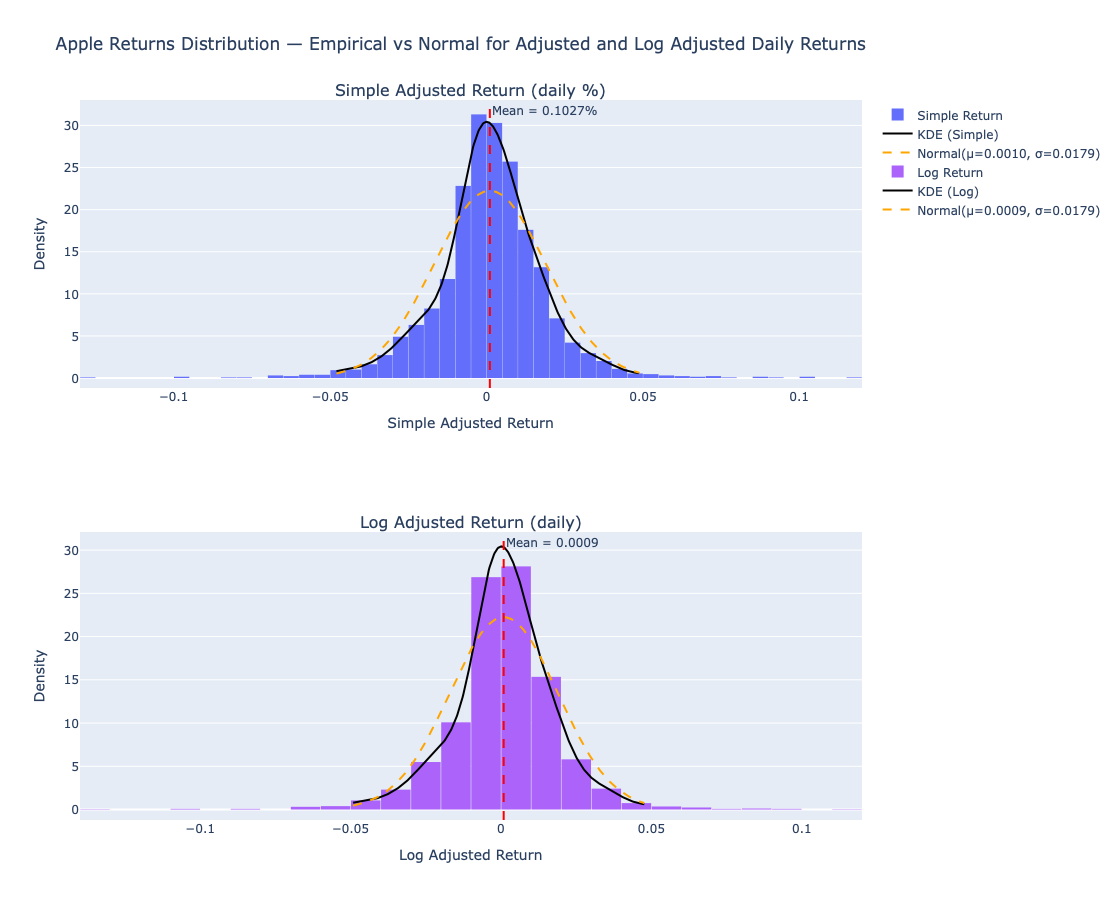

Area under KDE curve: 0.997622155815117


In [11]:
import numpy as np
from scipy.stats import gaussian_kde, norm
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Prepare data ---
x_simple = returns_df['Adj_Return'].dropna().values
x_log    = returns_df['Log_Adj_Return'].dropna().values

# Grids for smooth KDE lines (restrict to central 1%–99% to avoid extreme tails dominating)
grid_simple_min, grid_simple_max = np.quantile(x_simple, [0.01, 0.99])
grid_log_min,    grid_log_max    = np.quantile(x_log,    [0.01, 0.99])

grid_simple = np.linspace(grid_simple_min, grid_simple_max, 400)
grid_log    = np.linspace(grid_log_min,    grid_log_max,    400)

# KDE estimates
kde_simple = gaussian_kde(x_simple)
kde_log    = gaussian_kde(x_log)

# Normal distributions with same mean & std
mu_simple, sigma_simple = x_simple.mean(), x_simple.std()
mu_log, sigma_log       = x_log.mean(), x_log.std()

normal_simple = norm.pdf(grid_simple, mu_simple, sigma_simple)
normal_log    = norm.pdf(grid_log, mu_log, sigma_log)


# --- Create figure with 2 subplots ---
fig2 = make_subplots(
    rows=2, cols=1, 
    shared_xaxes=False,  
    vertical_spacing=0.2,  
    subplot_titles=("Simple Adjusted Return (daily %)", "Log Adjusted Return (daily)")
)

# ---- Top panel: Simple returns histogram ----
fig2.add_trace(
    go.Histogram(
        x=x_simple,
        name="Simple Return",
        nbinsx=60,
        histnorm="probability density",   # normalize so KDE is comparable
        marker=dict(line=dict(width=0)),
        hovertemplate="Simple Return: %{x:.4%}<extra></extra>"
    ),
    row=1, col=1
)

# Overlay KDE line
fig2.add_trace(
    go.Scatter(
        x=grid_simple, y=kde_simple(grid_simple),
        mode="lines", line=dict(color="black", width=2),
        name="KDE (Simple)"
    ),
    row=1, col=1
)

# Mean line (simple returns)
fig2.add_vline(
    x=float(x_simple.mean()),
    line_dash="dash", line_color="red", row=1, col=1,
    annotation_text=f"Mean = {x_simple.mean():.4%}", 
    annotation_position="top right"
)

# Normal curve (simple)
fig2.add_trace(go.Scatter(
    x=grid_simple, y=normal_simple,
    mode="lines", name=f"Normal(μ={mu_simple:.4f}, σ={sigma_simple:.4f})",
    line=dict(color="orange", dash="dash")
), row=1, col=1)


# ---- Bottom panel: Log returns histogram ----
fig2.add_trace(
    go.Histogram(
        x=x_log,
        name="Log Return",
        nbinsx=40,
        histnorm="probability density",   # normalize for KDE overlay
        marker=dict(line=dict(width=0)),
        hovertemplate="Log Return: %{x:.4f}<extra></extra>"
    ),
    row=2, col=1
)

# Overlay KDE line
fig2.add_trace(
    go.Scatter(
        x=grid_log, y=kde_log(grid_log),
        mode="lines", line=dict(color="black", width=2),
        name="KDE (Log)"
    ),
    row=2, col=1
)

# Mean line (log returns)
fig2.add_vline(
    x=float(x_log.mean()),
    line_dash="dash", line_color="red", row=2, col=1,
    annotation_text=f"Mean = {x_log.mean():.4f}", 
    annotation_position="top right"
)

# Normal curve (log)
fig2.add_trace(go.Scatter(
    x=grid_log, y=normal_log,
    mode="lines", name=f"Normal(μ={mu_log:.4f}, σ={sigma_log:.4f})",
    line=dict(color="orange", dash="dash")
), row=2, col=1)


# Update axes
fig2.update_xaxes(title_text="Simple Adjusted Return", row=1, col=1)
fig2.update_yaxes(title_text="Density", row=1, col=1)

fig2.update_xaxes(title_text="Log Adjusted Return", row=2, col=1)
fig2.update_yaxes(title_text="Density", row=2, col=1)

# Layout
fig2.update_layout(
    title="Apple Returns Distribution — Empirical vs Normal for Adjusted and Log Adjusted Daily Returns",
    bargap=0.02,
    height=900,
    width=1100,
    showlegend=True,
    hovermode="x unified",
)
fig2.update_traces(visible=True)
fig2.show()

from numpy import trapz

# Evaluate KDE on a grid
grid = np.linspace(np.quantile(x_simple, 0.001), np.quantile(x_simple, 0.999), 1000)
pdf_vals = kde_simple(grid)

# Approximate integral using trapezoidal rule
area = trapz(pdf_vals, grid)
print("Area under KDE curve:", area)

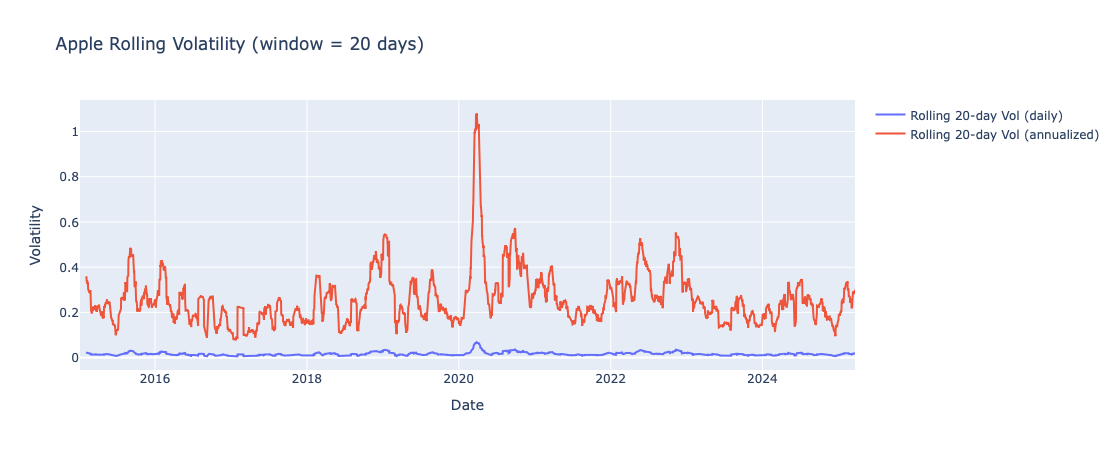

In [12]:
rolling_vol = apple['Adj_Return'].rolling(window).std()                     # daily rolling vol
rolling_vol_ann = rolling_vol * np.sqrt(252)                                # Annual rolling Vol
rolling_vol.dropna()
rolling_vol_ann.dropna()

# --- plot ---
fig_vol = go.Figure()
fig_vol.add_trace(go.Scatter(
    x=rolling_vol.index, y=rolling_vol,
    mode="lines", name=f"Rolling {window}-day Vol (daily)",
))
fig_vol.add_trace(go.Scatter(
    x=rolling_vol_ann.index, y=rolling_vol_ann,
    mode="lines", name=f"Rolling {window}-day Vol (annualized)",
))

fig_vol.update_layout(
    title=f"Apple Rolling Volatility (window = {window} days)",
    xaxis_title="Date",
    yaxis_title="Volatility",
    hovermode="x unified",
    height=450, width=1000,
)
fig_vol.show()